In [1]:
from sklearn import preprocessing
import os
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("preparedData.xlsx")

In [3]:
#df.replace(0,np.nan, inplace=True)

In [4]:
df.drop(columns=['tests_per_case', 
            'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations','population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'life_expectancy', 'human_development_index', 
       'COVID-19 testing: (Ireland)', 'COVID-19 rapid antigen test: (Ireland)',
       'Health Service Executive: (Ireland)', 'Vaccination: (Ireland)',
       'book covid test: (Ireland)_x', 'how many covid cases today: (Ireland)',
       'pcr covid test: (Ireland)', 'close contact covid: (Ireland)',
       'book a covid test: (Ireland)', 'vaccination centre: (Ireland)',
       'pharmacy near me: (Ireland)',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'book covid test: (Ireland)_y', 'covid test dublin: (Ireland)',
       'covid test centre: (Ireland)', 'hse covid vaccine: (Ireland)',
       'hse vaccine portal: (Ireland)', 'hse portal vaccine: (Ireland)',
       'pcr test hse: (Ireland)', 'hse covid test: (Ireland)',
       'hse vaccine registration: (Ireland)',
       'how long will it take to vaccinate ireland: (Ireland)'],inplace=True)

In [5]:
df.columns

Index(['date', 'new_cases', 'new_cases_smoothed', 'reproduction_rate',
       'new_tests', 'positive_rate', 'total_vaccinations', 'stringency_index',
       'covid: (Ireland)'],
      dtype='object')

In [6]:
date_time = pd.to_datetime(df.pop('date'), format='%d-%m-%Y')

In [7]:
df = df.astype(float)

In [8]:
df = df[:601]

In [9]:
#split the data 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_df)

In [11]:
cols = df.columns

In [12]:
train_scaled = scaler.transform(train_df.to_numpy())

In [13]:
train_scaled = pd.DataFrame(train_scaled,columns=cols)

In [14]:
val_scaled = scaler.transform(val_df.to_numpy())

In [15]:
val_scaled = pd.DataFrame(val_scaled,columns=cols)

In [16]:
test_scaled = scaler.transform(test_df.to_numpy())

In [17]:
test_scaled = pd.DataFrame(test_scaled,columns=cols)

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_scaled=train_scaled, val_scaled=val_scaled, test_scaled=test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_scaled = train_scaled
    self.val_scaled = val_scaled
    self.test_scaled = test_scaled

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_scaled.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [19]:
window = WindowGenerator(
    input_width=21, label_width=21, shift=3,
    label_columns=['new_cases_smoothed'])

window

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): ['new_cases_smoothed']

In [20]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [21]:
train_scaled.shape

(420, 8)

In [22]:
# Stack four slices, the length of the total window.
sample_window = tf.stack([np.array(train_scaled[:window.total_window_size]),
                           np.array(train_scaled[50:50+window.total_window_size]),
                           np.array(train_scaled[100:100+window.total_window_size]),
                           np.array(train_scaled[150:150+window.total_window_size]),
                           np.array(train_scaled[200:200+window.total_window_size]),
                           np.array(train_scaled[250:250+window.total_window_size]),])

sample_inputs, sample_labels = window.split_window(sample_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {sample_window.shape}')
print(f'Inputs shape: {sample_inputs.shape}')
print(f'Labels shape: {sample_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (6, 24, 8)
Inputs shape: (6, 21, 8)
Labels shape: (6, 21, 1)


In [23]:
window.sample = sample_inputs, sample_labels

In [24]:
def plot(self, model=None, plot_col='new_cases_smoothed', max_subplots=4):
  inputs, labels = self.sample
  plt.figure(figsize=(20, 20))
  
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.title('Actual and Predictions for 4 windows of the LSTM Model')
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
  
  plt.xlabel('new_cases_smoothed')
  plt.title('Actual and Predictions for 4 windows of the LSTM Model')
  plt.savefig("Model.jpg")

WindowGenerator.plot = plot

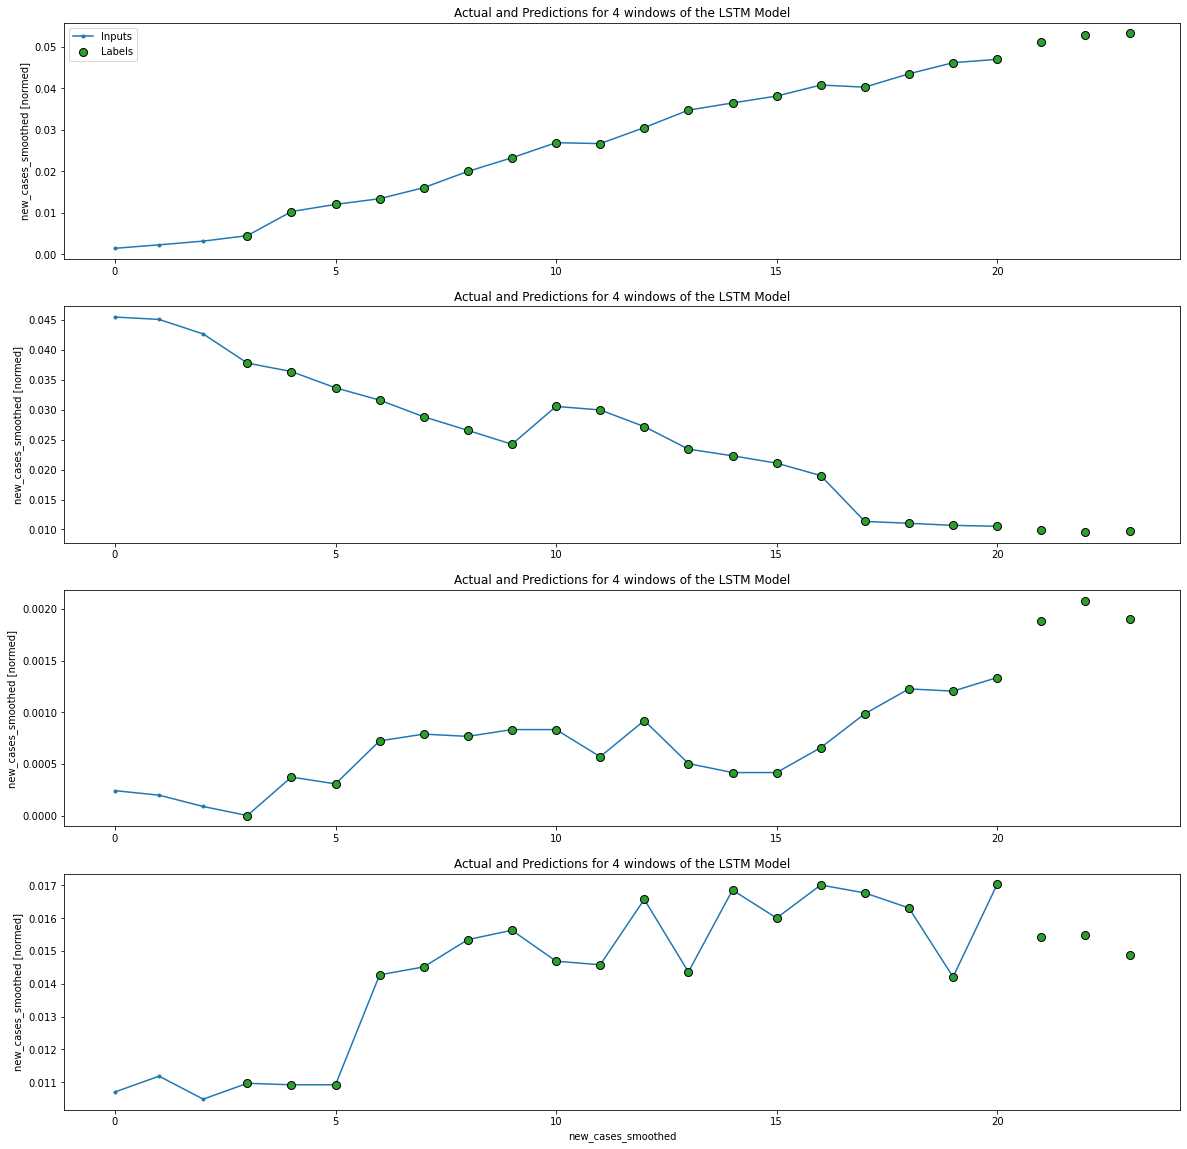

In [25]:
window.plot()

In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
  return self.make_dataset(self.train_scaled)

@property
def val(self):
  return self.make_dataset(self.val_scaled)

@property
def test(self):
  return self.make_dataset(self.test_scaled)

@property
def sample(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_sample', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.sample = sample

In [28]:
MAX_EPOCHS = 5000

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

#MeanAbsoluteError()

In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [30]:
baseline = Baseline(label_index=column_indices['new_cases_smoothed'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(window.val)
performance['Baseline'] = baseline.evaluate(window.test, verbose=0)

4/4 [==============================] - 0s 13ms/step - loss: 2.1890e-04 - mean_absolute_error: 0.0090


In [31]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta

In [32]:
from tensorflow.keras import layers

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1000, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(20, activation='selu', name="Layer_1"),
    tf.keras.layers.Dense(10, activation='selu', name="Layer_2"),
    tf.keras.layers.Dense(units=1,name="Layer_3")
    ])

In [33]:
print('Input shape:', window.sample[0].shape)
print('Output shape:', lstm_model(window.sample[0]).shape)

Input shape: (32, 21, 8)
Output shape: (32, 21, 1)


In [34]:
history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)


4/4 [==============================] - 0s 20ms/step - loss: 0.0095 - mean_absolute_error: 0.0856


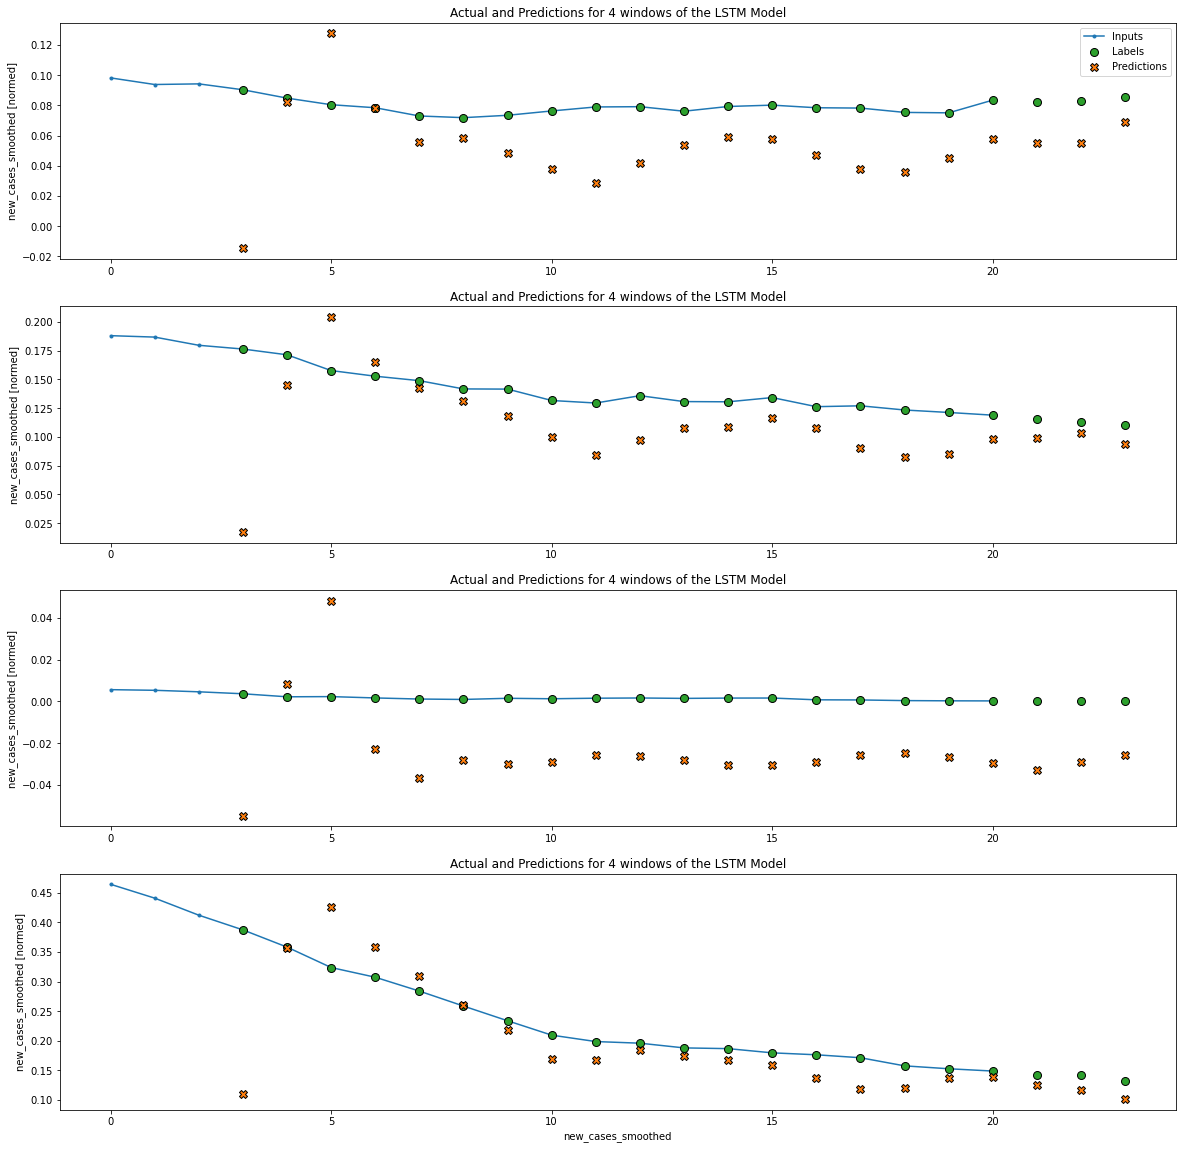

In [35]:
window.plot(lstm_model)

In [36]:
print(lstm_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 1000)          4036000   
                                                                 
 Layer_1 (Dense)             (None, 21, 20)            20020     
                                                                 
 Layer_2 (Dense)             (None, 21, 10)            210       
                                                                 
 Layer_3 (Dense)             (None, 21, 1)             11        
                                                                 
Total params: 4,056,241
Trainable params: 4,056,241
Non-trainable params: 0
_________________________________________________________________
None


Text(0.5, 1.0, 'LSTM vs. Baseline')

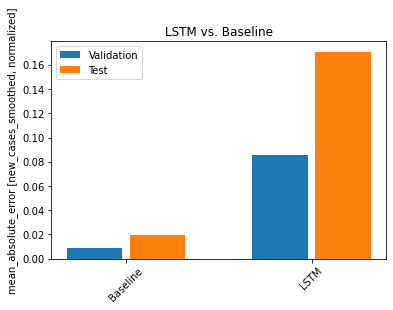

In [37]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [new_cases_smoothed, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.title("LSTM vs. Baseline")

In [38]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.0193
LSTM        : 0.1710


In [39]:
val_performance['LSTM'] 

[0.009506954811513424, 0.0856098085641861]